# Dependencies

more usefull information about the fields can be found at the data [source](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236).

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import datetime

## Some preprocessing

In [3]:
# Load flight data
df_fl = pd.read_csv("../flights.csv",dtype={"ORIGIN_AIRPORT":str,"DESTINATION_AIRPORT":str,"ARRIVAL_TIME":str,"DEPARTURE_TIME":str})

In [4]:
df_fl.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [5]:
#df_fl[["ORIGIN_AIRPORT","DESTINATION_AIRPORT","YEAR","MONTH","DAY","ARRIVAL_TIME","DEPARTURE_TIME"]]
#df_fl.YEAR + "-" + df_fl.MONTH + "-" + df_fl.DAY + "-" + df_fl.DEPARTURE_TIME

In [6]:
# Problem: airline codes not coherent:
print(len(df_fl["ORIGIN_AIRPORT"].unique()))

628


In [7]:
# Solution: map it
# load airport codes
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

# Format the airport codes
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))
aircode_dict["10423"]  = "AUS" # 10423 was encoded to BSM which is in IRAN istead of Austin-Bergstrom

# support function
def mymapper(label):
    """function to map 5-digit to 3-letter code"""
    if len(label) == 3:
        return label
    elif len(label) == 5:
        return aircode_dict[label]
    
# Fix the airport 5-digit > 3-letter code
df_fl['O_A'] = df_fl["ORIGIN_AIRPORT"].apply(mymapper)
df_fl["D_A"] = df_fl["DESTINATION_AIRPORT"].apply(mymapper)

In [8]:
# we finally find the 322 unique domestic airports
print((len(df_fl["D_A"].unique()),len(df_fl["O_A"].unique())))

(322, 322)


In [18]:
# Load up airports
airports = pd.read_csv('../airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [10]:
airports.shape

(322, 7)

In [11]:
# Get all the planes from the dataframe
planes = df_fl.TAIL_NUMBER.unique()


#### Fix the times from local to UTC

# Data exploration

In [12]:
df_fl.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'O_A', 'D_A'],
      dtype='object')

In [13]:
# Sneak peak
df_fl.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,O_A,D_A
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,SEA
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,PBI
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SFO,CLT
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,MIA
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SEA,ANC


In [14]:
# Amount of flights/airport
destsize = df_fl["D_A"].value_counts().sort_index()
orsize = df_fl["O_A"].value_counts().sort_index()

# Generate boolean variable to indicate delay
# x <= 0: False (i.e. no delay)
# x  > 0: True (i.e. delay)
df_fl["late_departure"] = [True if x > 0 else False for x in df_fl["DEPARTURE_DELAY"]]
df_fl["late_arrival"] = [True if x > 0 else False for x in df_fl["ARRIVAL_DELAY"]]

# Generate ratios of delayed flights for each airport
dept_delay_df = df_fl.pivot_table("late_departure",index="O_A")
arr_delay_df  = df_fl.pivot_table("late_arrival",index="D_A")
# put them together and sort on index (for plotting later on)
delaydf = pd.concat([dept_delay_df, arr_delay_df], axis=1).sort_index()

### Question: identify hubs (flight count & delays)

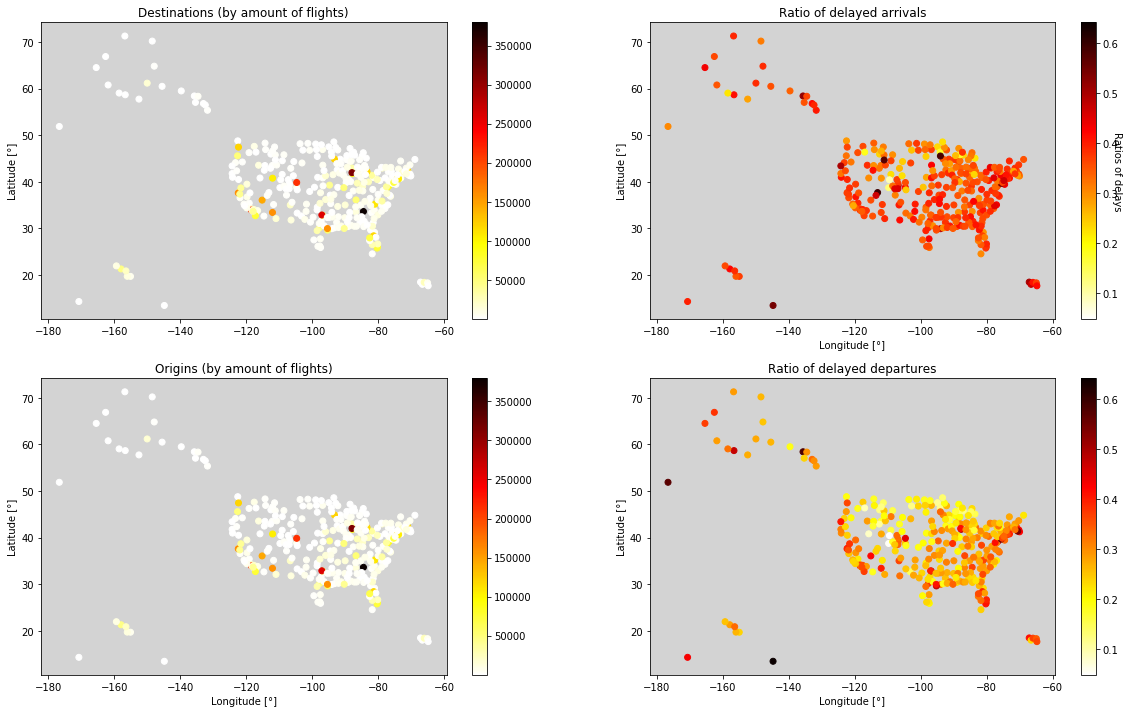

In [15]:
# Extract lat/long coordinates, sorted by IATA code
x = airports.sort_values(by="IATA_CODE")["LONGITUDE"].to_numpy()
y = airports.sort_values(by="IATA_CODE")["LATITUDE"].to_numpy()

# Make figure
plt.figure(figsize=(20,12))

# Showing airport importance based on number of flights
plt.subplot(2,2,1)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.ylabel("Latitude [°]")
plt.title("Destinations (by amount of flights)");
plt.colorbar();
#plt.clim(0,max(np.max(destsize),np.max(orsize)))

plt.subplot(2,2,3)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=orsize,cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Origins (by amount of flights)");
plt.colorbar();
#plt.clim(0,max(np.max(deptsize),np.max(orsize)))

# Showing ratio of delays for airports
plt.subplot(2,2,4)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_departure"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed departures");
cbar = plt.colorbar();
#cbar.set_label('Ratios of delayed departures', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

plt.subplot(2,2,2)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_arrival"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed arrivals");
cbar = plt.colorbar();
cbar.set_label('Ratios of delays', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

### Question: is there a correlation between late departure and late arrival?

In [16]:
from scipy.stats.stats import pearsonr
pearsonr(dept_delay_df,arr_delay_df)
# => positive corelation ratio, but not purely linear

(array([0.50558084]), array([2.68714463e-22]))

### Question: what does the delay distribution look like?

In [19]:
# get delay times
a = df_fl["ARRIVAL_DELAY"].dropna().to_numpy()
d = df_fl["DEPARTURE_DELAY"].dropna().to_numpy()
# calculate kernel
kernel_a = stats.gaussian_kde(a)
kernel_d = stats.gaussian_kde(d)
# generate variables
dtime = np.arange(-50,100)
y_a = kernel_a(dtime)
y_d = kernel_d(dtime);

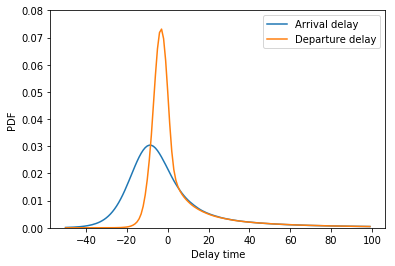

In [20]:
plt.plot(dtime,y_a,label="Arrival delay")
plt.plot(dtime,y_d,label="Departure delay")
plt.xlabel("Delay time")
plt.ylabel("PDF")
plt.legend();
plt.ylim(0,0.08);

### Q: what does the network look like?

In [86]:
# Get an idea of the flight combinations
flight_counts = df_fl.groupby(['O_A', 'D_A']).size()
# Get the edges and write the to a list:
edges = [(x[0], x[1], {'weight': flight_counts[x]}) for x in flight_counts.index.tolist()]
# generate network from edges
G = nx.DiGraph()
# add edges
G.add_edges_from(edges)
# export
nx.write_gexf(G,"flightnet.gexf")
# Correlation between network measures and e.g. delays etc.


#### Network measures - unweighted

### Cascade of delays study
We distinguish two types of delay which we call vertical and horizontal
* Vertical delay: "Successive delay for a specific plane"
* Horizontal delay: "successive delays for a specific airport"

We look specifically at the vertical delays and try to establish a transition matrix between two states (delayed/not-delayed) for each plane. We also look to what extent this idea holds for all planes.

In [58]:
def get_successive_delays(tailnumber,df):
    """
    Initial lazy approximation: if a plane has either a departure delay
    or an arrival delay, it is considered late.
    
    Input
    -----
    df - pd.dataframe
    tailnumber - string
        tailnumber of the plane
        
    Returns
    -------
    Successive delays - numpy.ndarray (Boolean)
            1 if late
            0 if on time
    """
    myf = df[df.TAIL_NUMBER == tailnumber][["late_departure","late_arrival"]]
    myf["delay"] = myf.late_departure | myf.late_arrival
    
    return myf["delay"].values.astype(int)

# plane_delays is a vector of 0s and 1s
def get_transition_matrix(plane_delays):
    """
    Determines transition matrix between two states (delayed - non-delayed)
    
    Input
    -----
    plane_delays - array
        containing only 0 and 1.
    
    Returns
    -------
    numpy.ndarray
        matrix with the transition probabilities
    """
    mat = np.zeros((2,2))
    for i in range(0,len(plane_delays)-1):
        mat[plane_delays[i],plane_delays[i+1]] += 1
    return np.array([row/sum(row) for row in mat])

# transition matrix distribution (principal component)
def trans_matrix_distribution(planes,df,limit=30,plot=False):
    """
    Extract distribution from diagonal the transition matrix
    """
    topleft = np.array([])
    lowerright = np.array([])
    for plane in planes[:30]:
        TM = get_transition_matrix(get_successive_delays(plane,df))
        topleft = np.append(topleft,[TM[0,0]])
        lowerright = np.append(lowerright,[TM[1,1]])
        
    if plot:
        # calculate kernel
        kernel_top = stats.gaussian_kde(topleft)
        kernel_low = stats.gaussian_kde(lowerright)
        # generate variables
        x = np.arange(0,1)
        y_a = kernel_top(x)
        y_b = kernel_low(x);
        plt.plot(x,y_a,label="topleft")
        plt.plot(x,y_b,label="lowerright")
        
    return (topleft,lowerright)
    
    
#plane_delays is np.array if it is only one series of delays or a list of np.arrays if it contains more. 
#It should be however from a single plane
def randomize_delays(plane_delays):
    if isinstance(plane_delays,np.ndarray):
        new_plane_delays = np.copy(plane_delays)
    elif isinstance(plane_delays,list):
        pass #this is needed when there are multilpe series for single plane
    np.random.shuffle(new_plane_delays)
    return new_plane_delays

#plane_delays is a list or numpy.array of plane delays, repetitions is number of randomization runs. 
#The smallest p-value is 2/repetitions
#Large p-value indicates a result is same as random. 
def get_pvalue_transition_matrix(plane_delays, repetitions=100):
    trans_mat = get_transition_matrix(plane_delays)
    vals_larger = np.zeros(trans_mat.shape)
    rand_trans_mats = np.zeros((repetitions, 2,2), float)
    for i in range(0, repetitions):
        new_seq = randomize_delays(plane_delays)
        rand_trans_mat = get_transition_matrix(new_seq)
        #below is a 'method' that gives 1 if real is larger then random, 0.5 if they are equal and 0 if they are different
        vals_larger += (np.sign(trans_mat - rand_trans_mat)+1)/2
        rand_trans_mats[i] = rand_trans_mat
    vals_larger /= repetitions
    pvals = np.array([2*min(x,1-x) for x in np.nditer(vals_larger)]).reshape(vals_larger.shape)
    return (pvals, np.min(rand_trans_mats[:,(0,1),(0,1)],0), 
            np.mean(rand_trans_mats[:,(0,1),(0,1)],0), np.median(rand_trans_mats[:,(0,1),(0,1)],0), 
            np.max(rand_trans_mats[:,(0,1),(0,1)],0))



In [60]:
# some unit testing
test_vector = [0, 1, 1, 1, 0, 0, 1]
answer = np.array([[1./3,2./3],[1./3,2./3]])
assert((answer == get_transition_matrix(test_vector)).all())
(answer == get_transition_matrix(test_vector)).all()

# testing the matrix generation
series = get_successive_delays(np.random.choice(planes),df_fl)
get_transition_matrix(series)


#test for get_pvalue_transition_matrix
np.random.seed(0)
test_vector = np.array([0, 1, 1, 1, 0, 0, 1])
expected_pvals = np.array([[0.91,0.91],[0.5,0.5]])

pvals = get_pvalue_transition_matrix(test_vector)[0]

print(expected_pvals-pvals)
print(np.isclose(pvals,expected_pvals))

assert(np.isclose(pvals,expected_pvals).all())



[[0.00000000e+00 1.11022302e-16]
 [0.00000000e+00 0.00000000e+00]]
[[ True  True]
 [ True  True]]


In [61]:
series = get_successive_delays(np.random.choice(planes),df_fl)
#transdist = trans_matrix_distribution(planes,df_fl)
print(series)
trans_mat = get_transition_matrix(series)
print(trans_mat)
get_pvalue_transition_matrix(series)

[1 1 0 ... 1 0 1]
[[0.73609802 0.26390198]
 [0.36505867 0.63494133]]


(array([[0., 0.],
        [0., 0.]]),
 array([0.5509434 , 0.37890625]),
 array([0.5795361 , 0.41912567]),
 array([0.57924528, 0.41889226]),
 array([0.5990566 , 0.44589309]))

In [39]:
rand_trans_mat = randomize_delays(series)
get_transition_matrix(rand_trans_mat)

array([[0.59763314, 0.40236686],
       [0.5674548 , 0.4325452 ]])

Finished 0 out of 4898.
Finished 200 out of 4898.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sign
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


Finished 400 out of 4898.
Finished 600 out of 4898.
Finished 800 out of 4898.
Finished 1000 out of 4898.
Finished 1200 out of 4898.
Finished 1400 out of 4898.
Finished 1600 out of 4898.
Finished 1800 out of 4898.
Finished 2000 out of 4898.
Finished 2200 out of 4898.
Finished 2400 out of 4898.
Finished 2600 out of 4898.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)


Finished 2800 out of 4898.
Finished 3000 out of 4898.
Finished 3200 out of 4898.
Finished 3400 out of 4898.
Finished 3600 out of 4898.
Finished 3800 out of 4898.
Finished 4000 out of 4898.
Finished 4200 out of 4898.
Finished 4400 out of 4898.
Finished 4600 out of 4898.
Finished 4800 out of 4898.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([4358.,   67.,   59.,   51.,   62.,   56.,   50.,   45.,   41.,
          94.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

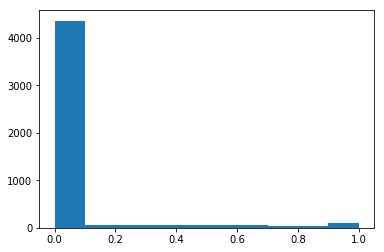

In [65]:
n_pl = len(planes)
trans_dd = np.zeros(n_pl, float)
trans_nn = np.zeros(n_pl, float)
pvals_dd = np.zeros(n_pl, float)
pvals_nn = np.zeros(n_pl, float)
mins = np.zeros((n_pl,2), float)
means = np.zeros((n_pl,2), float)
meds = np.zeros((n_pl,2), float)
maxs = np.zeros((n_pl,2), float)
for i, plane in enumerate(planes):
    #print(plane)
    series = get_successive_delays(plane,df_fl)
    #transdist = trans_matrix_distribution(planes,df_fl)
    #print(series)
    trans_mat = get_transition_matrix(series)
    trans_dd[i] = trans_mat[1,1]
    trans_nn[i] = trans_mat[0,0]
    #print(trans_mat)
    pvals, min_val, mean_val, med_val, max_val = get_pvalue_transition_matrix(series)
    pvals_dd[i] = pvals[1,1]
    pvals_nn[i] = pvals[0,0]
    mins[i,:] = min_val
    means[i,:] = mean_val
    meds[i,:] = med_val
    maxs[i,:] = max_val
    #display
    if (i%200==0):
        print('Finished ' + str(i) + ' out of ' + str(len(planes)) +  '.')

plt.hist(pvals_dd)

(array([4.183e+03, 1.900e+01, 3.800e+01, 1.500e+01, 1.600e+01, 9.000e+00,
        1.100e+01, 7.000e+00, 4.000e+00, 7.000e+00, 1.200e+01, 4.000e+00,
        1.400e+01, 8.000e+00, 4.000e+00, 8.000e+00, 6.000e+00, 8.000e+00,
        4.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 1.000e+00,
        9.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 9.000e+00,
        1.000e+01, 8.000e+00, 7.000e+00, 5.000e+00, 1.500e+01, 5.000e+00,
        8.000e+00, 5.000e+00, 4.000e+00, 7.000e+00, 9.000e+00, 1.000e+00,
        7.000e+00, 2.000e+00, 4.000e+00, 1.000e+01, 1.000e+01, 0.000e+00,
        3.000e+00, 4.000e+00, 7.000e+00, 1.000e+00, 5.000e+00, 6.000e+00,
        1.000e+00, 4.000e+00, 7.000e+00, 2.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 4.000e+00,
        5.000e+00, 6.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 9.000e+00,
        8.000e+00, 7.000e+00, 8.000e+0

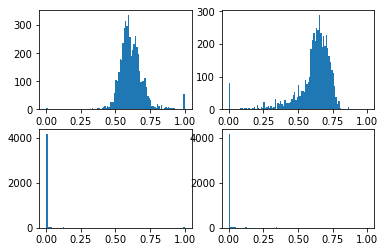

In [33]:
plt.subplot(2,2,1)
plt.hist(trans_dd, 100)
plt.subplot(2,2,2)
plt.hist(trans_nn, 100)
plt.subplot(2,2,3)
plt.hist(pvals_dd, 100)
plt.subplot(2,2,4)
plt.hist(pvals_nn, 100)

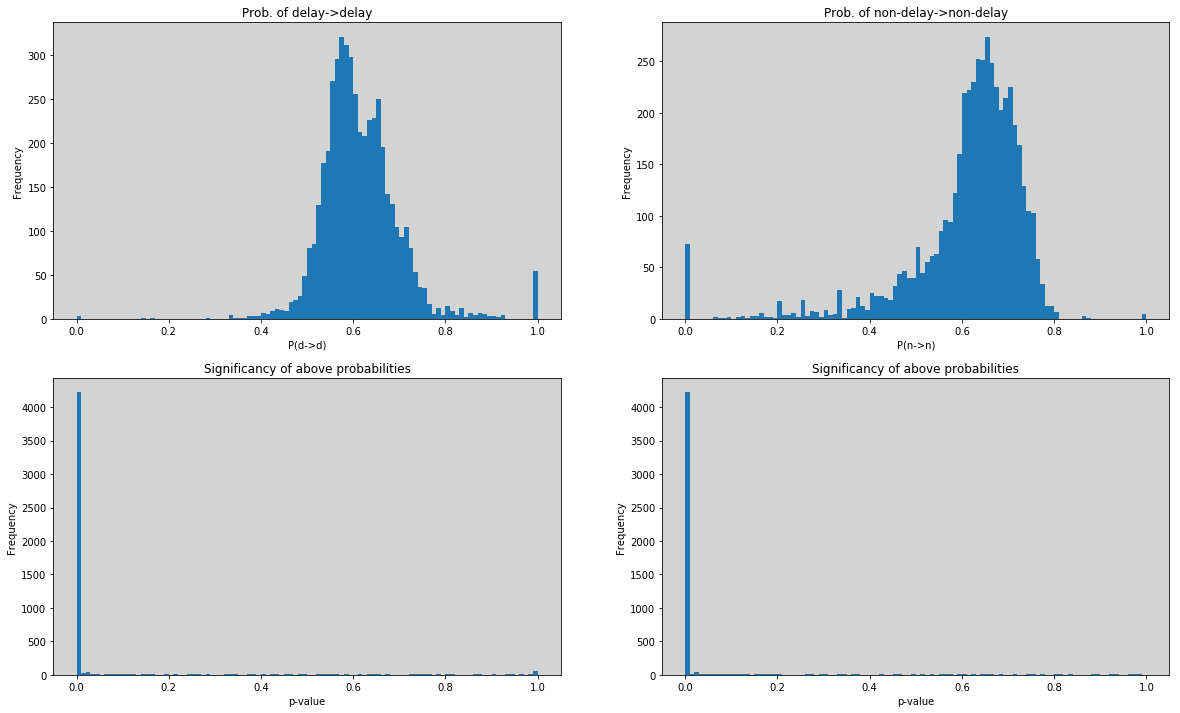

In [66]:
# Make figure
plt.figure(figsize=(20,12))

# Showing airport importance based on number of flights
plt.subplot(2,2,1)
ax = plt.gca()
ax.set_facecolor('lightgrey')
#plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.hist(trans_dd, 100)
plt.ylabel("Frequency")
plt.title("Prob. of delay->delay");
plt.xlabel("P(d->d)")
#plt.colorbar();
#plt.clim(0,max(np.max(destsize),np.max(orsize)))

plt.subplot(2,2,2)
ax = plt.gca()
ax.set_facecolor('lightgrey')
#plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.hist(trans_nn, 100)
plt.ylabel("Frequency")
plt.xlabel("P(n->n)")
plt.title("Prob. of non-delay->non-delay");

# Showing ratio of delays for airports
plt.subplot(2,2,3)
ax = plt.gca()
ax.set_facecolor('lightgrey')
#plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.hist(pvals_dd, 100)
plt.ylabel("Frequency")
plt.xlabel("p-value")
plt.title("Significancy of above probabilities");

plt.subplot(2,2,4)
ax = plt.gca()
ax.set_facecolor('lightgrey')
#plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.hist(pvals_nn, 100)
plt.ylabel("Frequency")
plt.xlabel("p-value")
plt.title("Significancy of above probabilities");

# The above result (of ALL planes) means most of data are not random. 

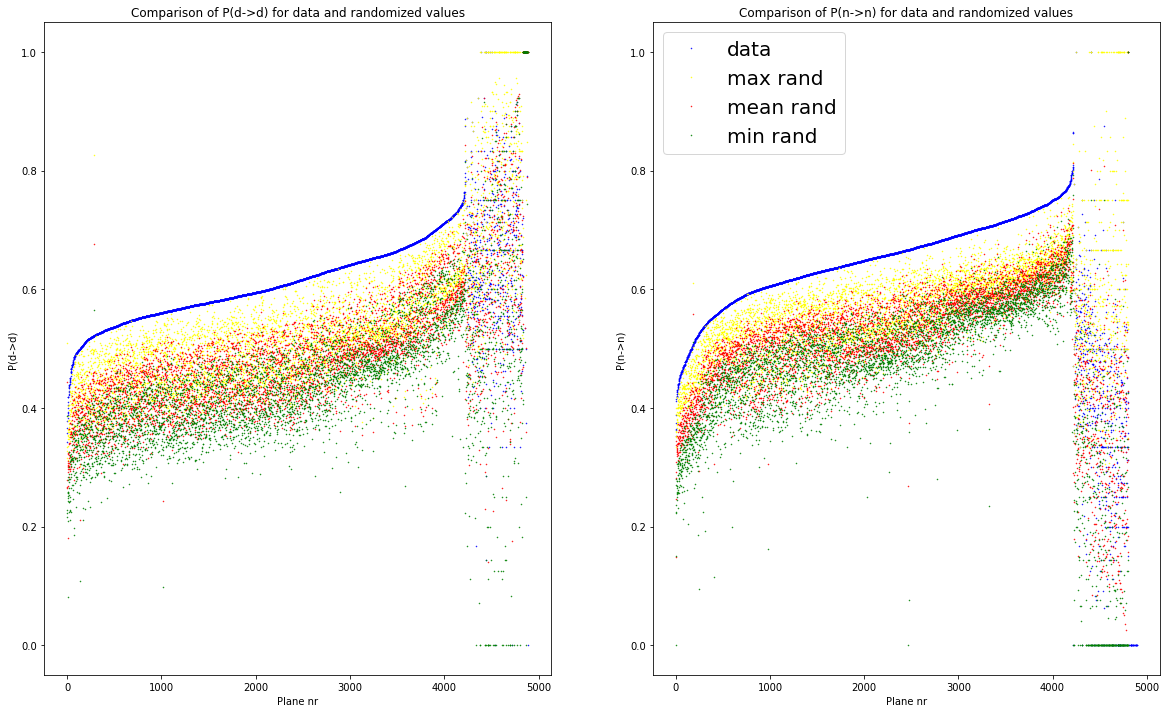

In [107]:
inds_dd = np.argsort(pvals_dd)
p0 = np.sum(pvals_dd==0)
inds_dd2 = np.argsort(trans_dd[inds_dd][0:p0])
inds_dd3 = np.concatenate((inds_dd[inds_dd2], inds_dd[p0:]))
#inds_nn = np.argsort(trans_nn)

plt.figure(figsize=(20,12))
plt.subplot(1,2,1)
plt.plot(trans_dd[inds_dd3], c='blue',linewidth=0,marker=".",markersize=1)
plt.plot(maxs[inds_dd3,1], c='yellow',linewidth=0,marker=".",markersize=1)
plt.plot(means[inds_dd3,1], c='red',linewidth=0,marker=".",markersize=1)
plt.plot(mins[inds_dd3,1], c='green',linewidth=0,marker=".",markersize=1)
#plt.bar(inds_dd3,pvals_dd/10)
plt.ylabel("P(d->d)")
plt.xlabel("Plane nr")
plt.title("Comparison of P(d->d) for data and randomized values");

inds_nn = np.argsort(pvals_nn)
p0nn = np.sum(pvals_nn==0)
inds_nn2 = np.argsort(trans_nn[inds_nn][0:p0nn])
inds_nn3 = np.concatenate((inds_nn[inds_nn2], inds_nn[p0nn:]))

plt.subplot(1,2,2)
plt.plot(trans_nn[inds_nn3], c='blue',linewidth=0,marker=".",markersize=1)
plt.plot(maxs[inds_nn3,0], c='yellow',linewidth=0,marker=".",markersize=1)
plt.plot(means[inds_nn3,0], c='red',linewidth=0,marker=".",markersize=1)
plt.plot(mins[inds_nn3,0], c='green',linewidth=0,marker=".",markersize=1)
plt.ylabel("P(n->n)")
plt.xlabel("Plane nr")
plt.title("Comparison of P(n->n) for data and randomized values");
plt.legend(('data', 'max rand', 'mean rand', 'min rand'), prop={'size': 20})

In [100]:
p0nn-p0

0

In [50]:
np.random.rand(3,2,2)

array([[[0.33907602, 0.26012993],
        [0.03418683, 0.93127355]],

       [[0.6246579 , 0.3453778 ],
        [0.12809406, 0.55367382]],

       [[0.87172948, 0.29689734],
        [0.70405437, 0.3169    ]]])